# **Camera Image noise Model**

Most of the time image noise is added as white Gaussian Noise, however this is not a true representation of noise in a digital camera. Noise in a digital camera is dependent on scene irradiance (light hitting a surface), and it is also spatially correlated due to demosaicing. In a digital color camera, the the color channels are usually undersampled with a Bayer filter and they must be interpolated in order to reconstruct the image. This interpolation is called demosaicing.

Understanding how a camera works will provide a good intuition of how to model this noise. A full digitial camera pipeline is shown below, but we will derive a simple camera model.


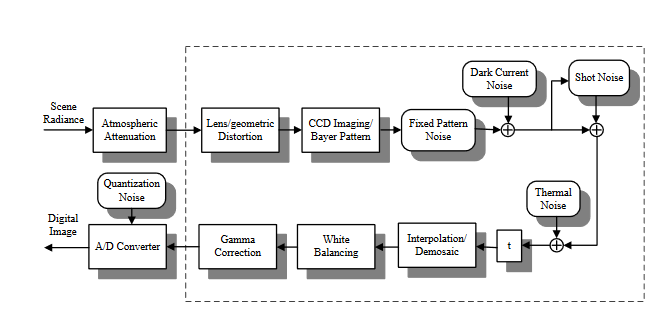

Digital Camera Imaging pipeline

## Digital Camera Model 

A digital camera is an imaging system that maps scene irradiance ($L$) at the image sensor to an image intensity ($I$). This mapping can be modeled as a Camera Response Function (CRF), which we will denote as $f$. The CRF can be though of as a transformation, we assume that this transformation is invertable, i.e. that $f^{-1}$ exists. Below we express the final image as a function of only scene irradiance, we refer to this function as our camera model or imaging model. 

$ 
\begin{equation}
I = f(L)  
\end{equation}
$

For now just think of the CRF ($f$) as an operator that can be inverted ($f^{-1}$). We will address how to find later on.

There are many noise components in our imaging model: fixed pattern noise, dark current noise, shot noise,
amplifier noise and quantization noise. However, we will only consider 2 main noise components: noise that depends on scen irradiance and noise that does not depend on scene irradiance. For more information on image noise, please see this [paper](https://www.ri.cmu.edu/pub_files/pub3/tsin_yanghai_2001_3/tsin_yanghai_2001_3.pdf).

- Gaussian Noise that depends on scene irradiance: $n_s \sim \mathcal{N}(0, L\sigma^2)$
- Gaussian Noise that is independent of scene irradiance: $n_c \sim \mathcal{N}(0, \sigma^2)$


In our model each of these noise components is directly added to all pixels, we can now express our imaging model as:
$ 
\begin{equation}
I = f(L + n_s + n_c)  \tag{2}
\end{equation}
$

The question remains of how exactly do we implement this? Since the noise is supposed to be spatially correlated we will need to do more than just add the noise. Also we need to consider the scene irradiance $L$, we will need to first transform the image with the inverse CRF to get the scene irradiance. The approach taken by the authors of this [paper](https://people.csail.mit.edu/billf/publications/Noise_Estimation_Single_Image.pdf) to obtain the noisy image $I_N$ is shown below as a function, were the both and Bayer Pattern and Demosaicing operation are represented as a single operator denoted: $d$. We will refer to this function as our noisy image model.

$
\begin{equation}
I_N = I + (d(f(L + n_s + n_c)) - d(f(L))) \tag{3}
\end{equation}
$

To simplify the notation, we naivley compose the demosaicing and camera response functions as: $ d \cdot f \rightarrow \tilde{f}$, now we re-write the noisy imaging model as:

$
\begin{equation}
I_N = I + (\tilde{f}(L + n_s + n_c) - \tilde{f}(L)) \tag{4}
\end{equation}
$

A flow diagram of this process is shown below.

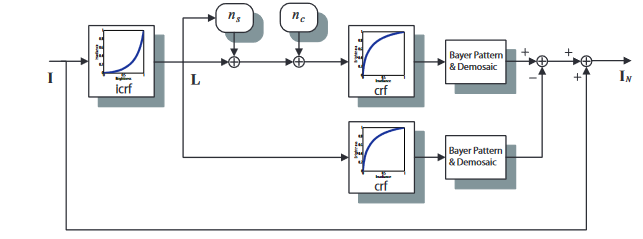

Image noise generation pipeline

Now it's time to address the CRF, the CRF can be estimated by taking many images of the same scene, however that would be time consuming and may not even be accurate. Instead we will use a database of CRF's located here: https://cave.cs.columbia.edu/repository/DoRF. Let's explore these CRFs a bit to get a feel for how they look. Each CRF is normalized between [0-1] and monotonically increasing.

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 5)

The CRF database is contained in a single .txt file. The format is:

"Camera Name" <br>
"Original format" <br>
"I=" <br>
"Intesity values" <br>
"B=" <br>
"Brightness values" <br>

This means a new camera CRF appears every 6 rows, we will write a helper function to obtain the $i^{th}$ CRF. This function will returin normalized Scene Irradiance (I) and Normalized Image Brightness B, not to be confused with any of the previous equations.

In [2]:
import csv

def get_crf(camera_idx):
    """ Obtains desired Camera Response Function (CRF)
        Inputs:
            camera_idx - index of CRF to obtain
        Outputs
            I - Scene Irradiance (1024, 1) array
            B - Image Brightness (1024, 1) array
        """
    # desired camera index
    camera_idx *= 6

    with open("dorfCurves.txt", 'r') as fobj:
        reader = csv.reader(fobj, delimiter=' ')
        rows = list(reader)

        I = rows[camera_idx + 3] 
        B = rows[camera_idx + 5]

        I = [float(val) for val in filter(
                lambda x: True if len(x) > 0 else False, I)]
        B = [float(val) for val in filter(
                lambda x: True if len(x) > 0 else False, B)]

        return I, B

To get our response functions, we will just take the average of the first 190 CRFs in the database for simplicity.

In [3]:
I = []
B = []
for i in range(190):
    _I, _B = get_crf(i)
    I.append(_I)
    B.append(_B)

In [4]:
I = np.array(I).mean(axis=0)
B = np.array(B).mean(axis=0)

Text(0, 0.5, 'Image Brightness')

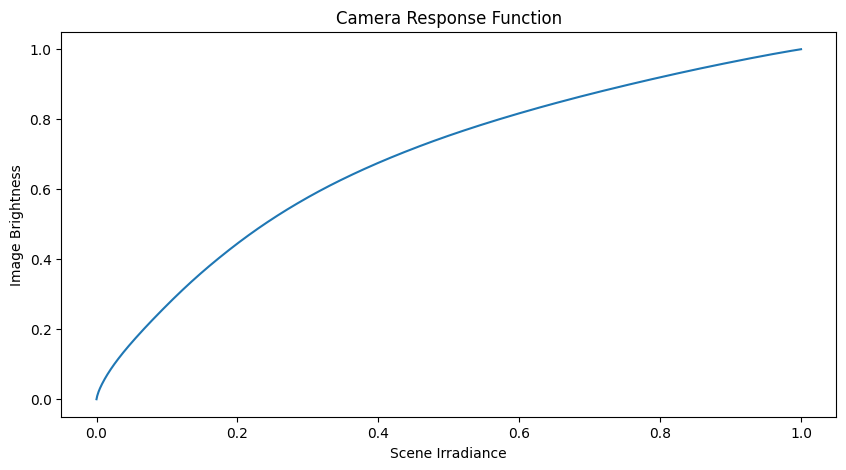

In [5]:
# I, B = get_crf(50)

plt.plot(I, B)
plt.title("Camera Response Function")
plt.xlabel("Scene Irradiance")
plt.ylabel("Image Brightness")

Text(0, 0.5, 'Scene Irradiance')

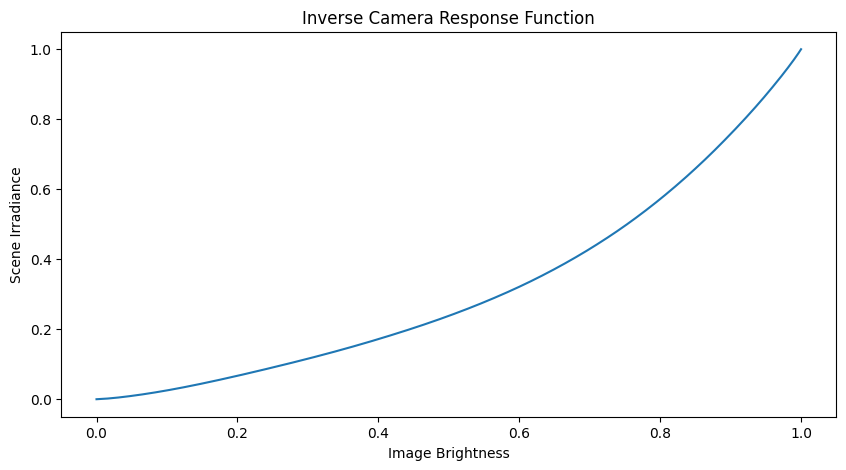

In [6]:
plt.plot(B, I)
plt.title("Inverse Camera Response Function")
plt.xlabel("Image Brightness")
plt.ylabel("Scene Irradiance")

Now that we know what the CRF looks like, let's turn these values into a function that we can actually use on an image.

In [7]:
# TEMP
# save I and B to be used later
# df = pd.DataFrame(np.array([I, B]).T, columns=["Scene Irradiance", "Image Brightness"])
# df.to_csv("crf.csv", index=False)

In [8]:
from scipy.interpolate import interp1d

crf = interp1d(I, B, kind='cubic')
icrf = interp1d(B, I, kind='cubic')

Now let's load an image and add some noise

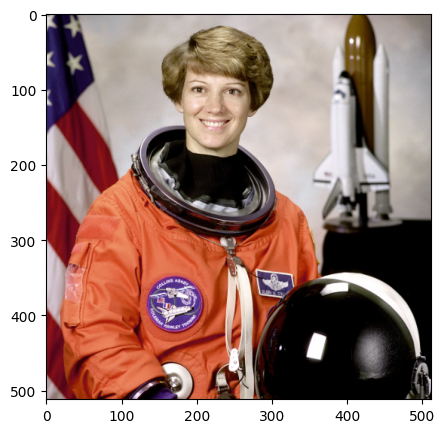

In [9]:
from skimage.data import astronaut

image_rgb = astronaut()
plt.imshow(image_rgb)

Now let's apply the inverse CRF to get the scene irradiance plane. First we will normalize the original image to make things easier.

In [10]:
image = cv2.normalize(image_rgb, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

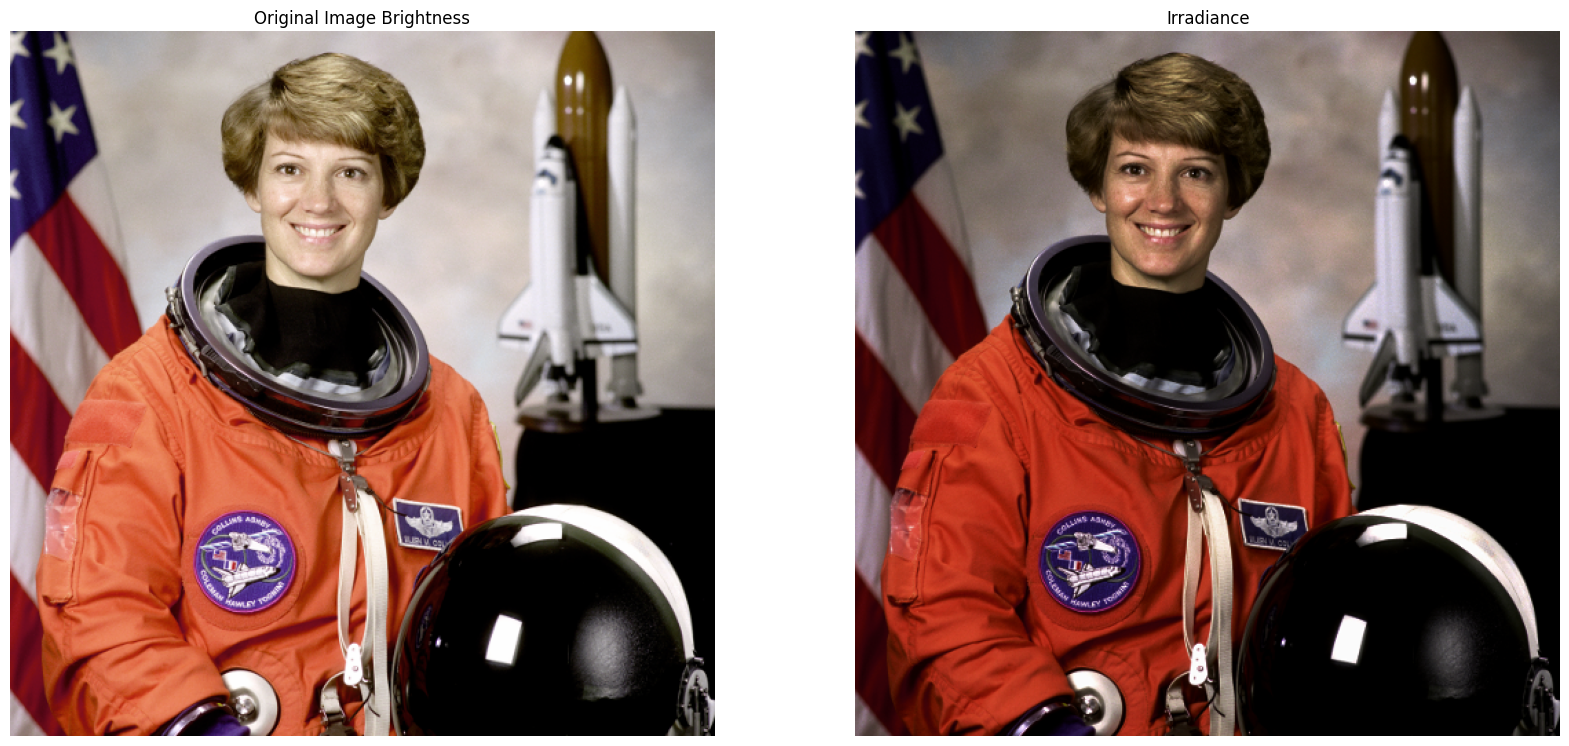

In [11]:
irradiance = icrf(image)

_, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(image)
ax[0].axis(False)
ax[0].set_title("Original Image Brightness")

ax[1].imshow(irradiance)
ax[1].axis(False)
ax[1].set_title("Irradiance");

In order to move on and implement our image noise model, we will need to finally address the $d$ operator. This operator is inverse Bayer patter plus demosaicing. For the inverse Bayer pattern, we will need to sample each pixel according to the patter of the standard Bayer Filter. For the demosaicing, we will leverage opencv to perform the interpolation.

### Implement the Inverse Bayer filtering
rgb 3 channel image --> bggr 1 channel image

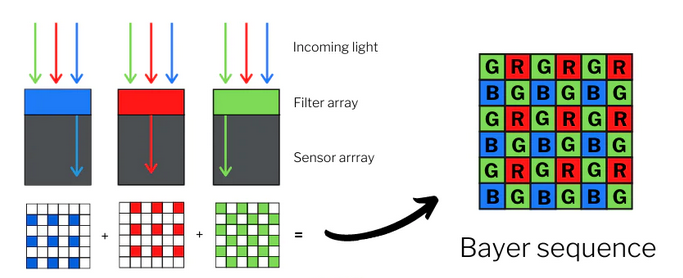


We will implement a function that can obtain the Inverse Bayer Filtering of each RGB color channel. The code was inspired from this StackOverflow answer: https://stackoverflow.com/questions/73894056/bayer-pattern-with-python

In [12]:
def inverse_bayer(image_rgb):
    """ Obtains inverse Bayer filtered image
        Inputs:
            image_rgb - (array) rgb image to be filtered
        Outputs:
            bayer_rgb - RGB channel inverse Bayer Bayer image
        """
    (R, G, B) = cv2.split(image_rgb)

    (height, width) = image_rgb.shape[:2]
    bayer = np.empty((height, width), np.uint8)

    # strided slicing for this pattern:
    #   G R
    #   B G
    bayer[0::2, 0::2] = G[0::2, 0::2] # top left
    bayer[0::2, 1::2] = R[0::2, 1::2] # top right
    bayer[1::2, 0::2] = B[1::2, 0::2] # bottom left
    bayer[1::2, 1::2] = G[1::2, 1::2] # bottom right
    #bayer = cv2.resize(bayer, None, fx=3, fy=3, interpolation=cv2.INTER_NEAREST)

    bayer_rgb = cv2.cvtColor(bayer, cv2.COLOR_GRAY2RGB)  # Convert from Grayscale to RGB (r=g=b for each pixel).
    bayer_rgb[0::2, 0::2, 0::2] = 0  # Green pixels - set the blue and the red planes to zero (and keep the green)
    bayer_rgb[0::2, 1::2, 1:] = 0   # Red pixels - set the blue and the green planes to zero (and keep the red)
    bayer_rgb[1::2, 0::2, 0:2] = 0    # Blue pixels - set the red and the green planes to zero (and keep the blue)
    bayer_rgb[1::2, 1::2, 0::2] = 0  # Green pixels - set the blue and the red planes to zero (and keep the green)

    return bayer_rgb

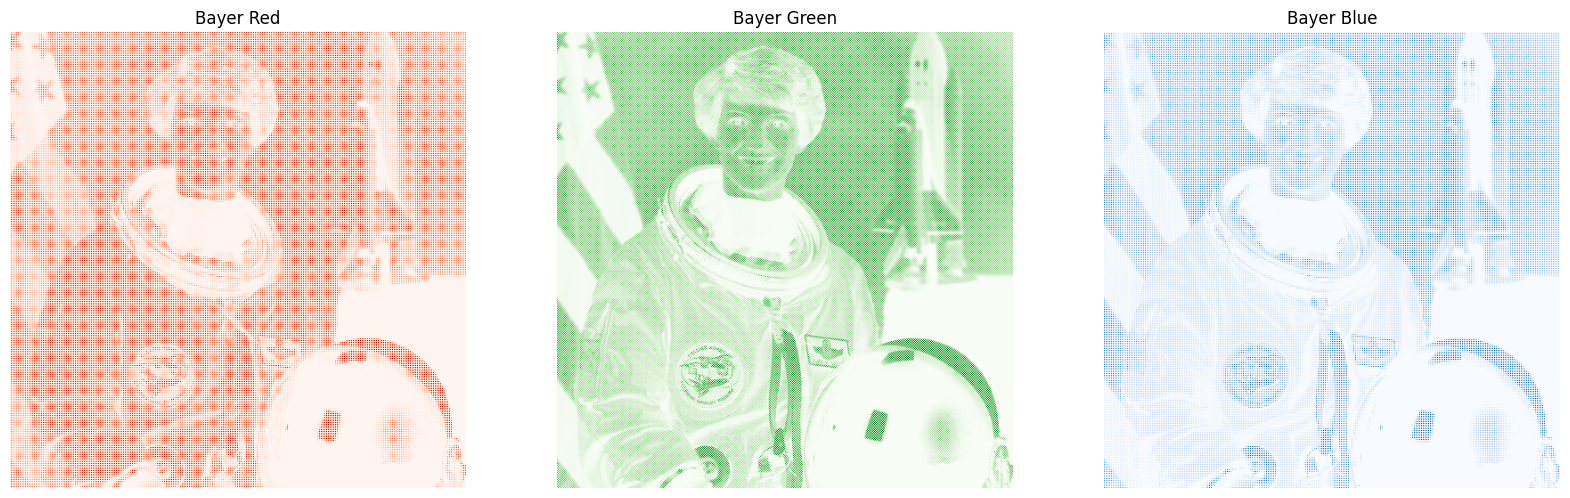

In [13]:
# get individual Bayer Filters
bayer_rgb = inverse_bayer(image_rgb)

_, ax = plt.subplots(1, 3, figsize=(20,10))
ax[0].imshow(bayer_rgb[:, :, 0], cmap='Reds')
ax[0].axis(False)
ax[0].set_title("Bayer Red")

ax[1].imshow(bayer_rgb[:, :, 1], cmap='Greens')
ax[1].axis(False)
ax[1].set_title("Bayer Green")

ax[2].imshow(bayer_rgb[:, :, 2], cmap='Blues')
ax[2].axis(False)
ax[2].set_title("Bayer Blue");

The undersampling is apparent in each of the Bayer RGB channels. The Green has twice as many samples as the red and blue, we can observe this difference by looking at the finer details of the image such as the patch on the uniform or even the shadow on the helmet. Now let's take a look at the actual Bayer image.

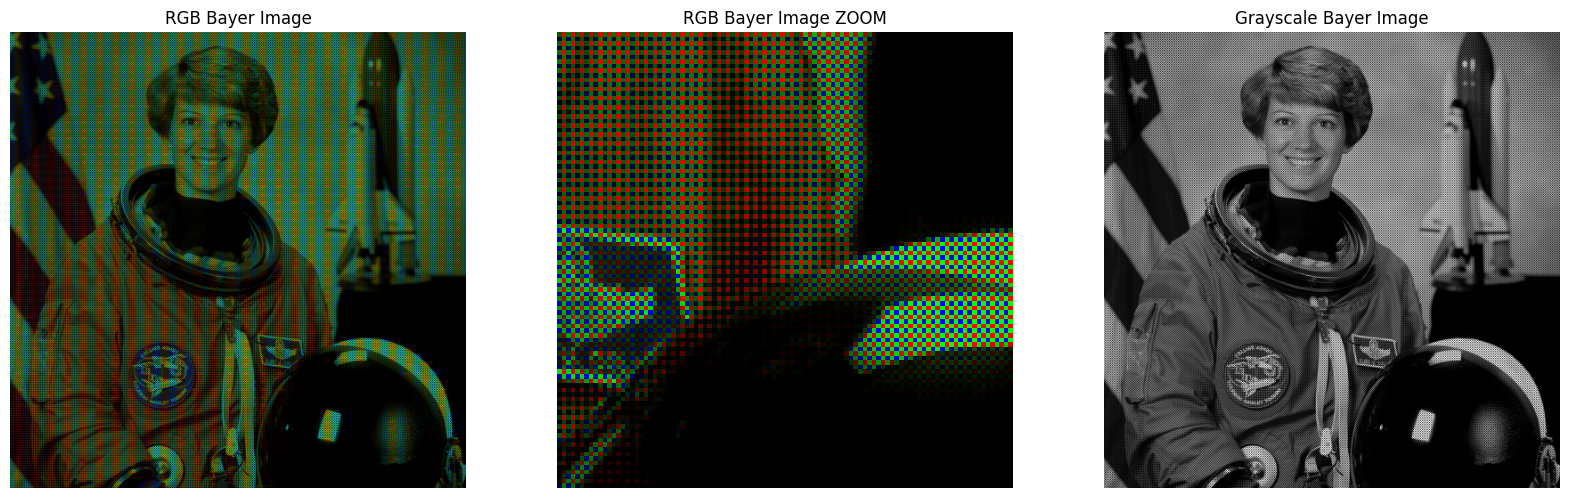

In [14]:
# Get singl channel Bayer Image
bayer = cv2.cvtColor(bayer_rgb, cv2.COLOR_BGR2GRAY)

_, ax = plt.subplots(1, 3, figsize=(20,10))
ax[0].imshow(bayer_rgb)
ax[0].axis(False)
ax[0].set_title("RGB Bayer Image")

ax[1].imshow(bayer_rgb[300:400, 300:400])
ax[1].axis(False)
ax[1].set_title("RGB Bayer Image ZOOM")

ax[2].imshow(bayer, cmap="gray")
ax[2].axis(False)
ax[2].set_title("Grayscale Bayer Image");

Notice how there are still some artifacts on the grayscale Bayer image. Let's take a closer look below

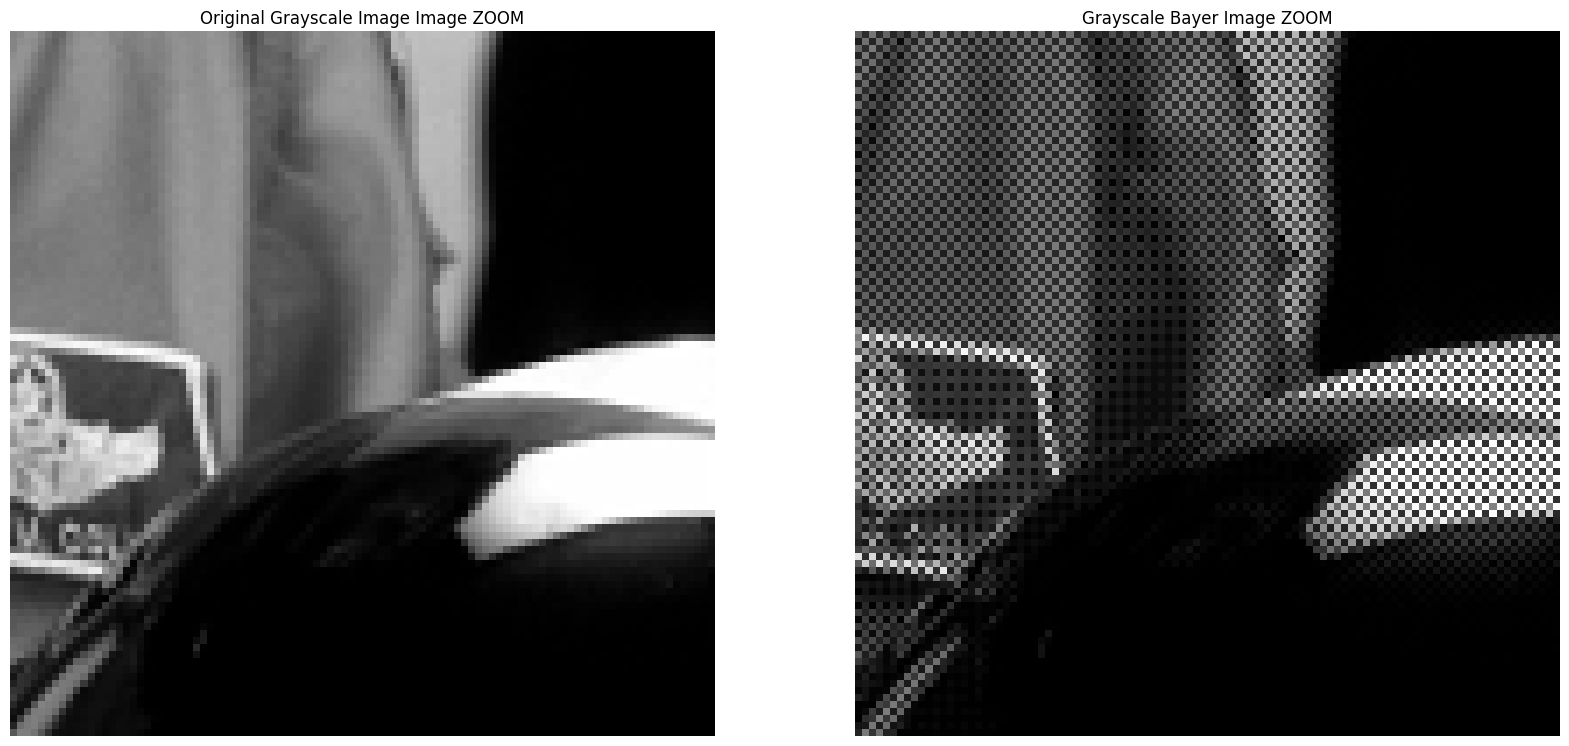

In [15]:
_, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].imshow(cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)[300:400, 300:400], cmap="gray")
ax[0].axis(False)
ax[0].set_title("Original Grayscale Image Image ZOOM")

ax[1].imshow(bayer[300:400, 300:400], cmap="gray")
ax[1].axis(False)
ax[1].set_title("Grayscale Bayer Image ZOOM");



The demosaicing will actually remove these artifacts. 

http://www.siliconimaging.com/RGB%20Bayer.htm


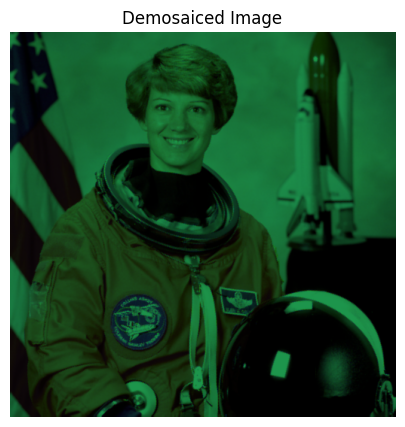

In [17]:
demosc = cv2.demosaicing(bayer, dst=None, code=cv2.COLOR_BAYER_GRBG2RGB, dstCn=3)
plt.imshow(demosc);
plt.title("Demosaiced Image")
plt.axis('off');

Notice how the color is a bit off, this is because we still need to perform white balancing and gamma correction, however these are outside the scope of this tutorial. Instead we will consider the main task of adding noise to the image and use a simple trick to deal with this.

We will inverse Bayer and Demosaic both a noisy and clean image and subtract, the clean from the noisy to obtain noise values for each pixel, we can then add that nosie directly to the original image. So in this manner, we have actually come up with a way to directly add image noise that is more representative of true image noise. Remeber that this noise is the addition of 2 noise processes, one that is depended on scene irradiance ($n_s$) and another that is completely independent ($n_c$). Both noise processes are assumed be Gaussian with zero mean.

Let's put this together below, we will create two functions one for creating Independent and Identiaclly Distributed (iid) Gaussian Random Noise and another for Generating noise according to our camera model.

In [47]:
def add_iid_noise(image_rgb, crf, icrf, s_sigma=0.02, c_sigma=0.02, c=10):
    """ Obtains iid noise for the respective image input.
        Inputs:
            image - (array) RGB image to add noise to  (can also be single channel)
            crf - Camera Response Functoion
            icrf - Inverse Camera Response Functoion
            s_sigma - Std Dev of noise process dependent on irradiance
            c_sigma - Std Dev of noise process independent of irradiance
            c - scale factor for ns to prevent underflow from multiplying values < 0
        Outputs:
            noise - (array) iid noise normalized to 0-255 (uint8)
        """
    # normalize image
    image = cv2.normalize(image_rgb, None, alpha=0, beta=1, 
                          norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # get scene irradiance
    irradiance = icrf(image)
    
    # Generate Random Noise 
    ns = np.random.normal(0, s_sigma, size=irradiance.shape)*np.sqrt(irradiance)*c
    nc = np.random.normal(0, c_sigma, size=irradiance.shape)

    # get Independent Identically Distributed (iid) noise on the image
    iid_noise = crf(np.clip(irradiance + ns + nc, 0, 1))
    return cv2.normalize(iid_noise, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)


def get_camera_noise(image_rgb, crf, icrf, s_sigma=0.02, c_sigma=0.02, c=10):
    """ Obtains Camera noise for the respective image input. Camera
        Noise referes to noise added according to a camera model that 
        considers noise to come from 2 separate processes. One that depends
        on scene irradiance (ns) and another the is independent (nc), since
        both noise sources are added before Demosaicing, demosaicing is simulated
        and introduced spatial correlations in the noise.
        Inputs:
            image_rgb - (array) RGB image to add noise to 
            crf - Camera Response Functoion
            icrf - Inverse Camera Response Functoion
            s_sigma - Std Dev of noise process dependent on irradiance
            c_sigma - Std Dev of noise process independent of irradiance
            c - scale factor for ns to prevent underflow from multiplying values < 0
        Outputs:
            noise - (array) correlated camera noise 
        """
    iid_noise_image = add_iid_noise(image_rgb, crf, icrf, s_sigma, c_sigma, c)

    # perform inverse Bayer Filtering
    bayer = cv2.cvtColor(inverse_bayer(image_rgb), cv2.COLOR_RGB2GRAY)
    bayer_noise = cv2.cvtColor(inverse_bayer(iid_noise_image), cv2.COLOR_RGB2GRAY)

    # Demosaic inverse Bayer Filtered images
    demosc = cv2.demosaicing(bayer, dst=None, code=cv2.COLOR_BAYER_GRBG2RGB, dstCn=3)
    demosc_noise = cv2.demosaicing(bayer_noise, dst=None, code=cv2.COLOR_BAYER_GRBG2RGB, dstCn=3)

    # subtract the image from the noisy image, leaving only thr noise
    return demosc_noise - demosc


In [48]:
I_n1 = add_iid_noise(image_rgb, crf, icrf, s_sigma=0.025, c_sigma=0.025)
camera_noise = get_camera_noise(image_rgb, crf, icrf, s_sigma=0.025, c_sigma=0.025)

iid_noise = I_n1 - image_rgb
I_n2 = image_rgb + camera_noise

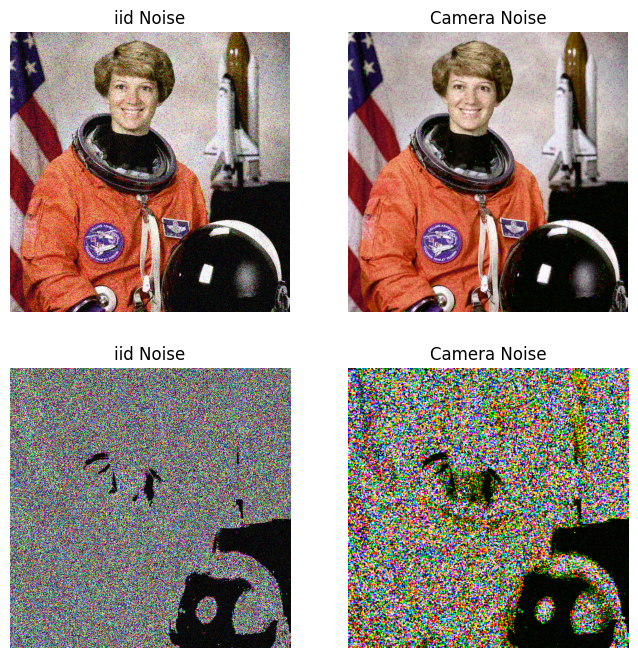

In [49]:
_, ax = plt.subplots(2, 2, figsize=(8,8))

ax[0][0].imshow(I_n1)
ax[0][0].axis(False)
ax[0][0].set_title("iid Noise")

ax[0][1].imshow(I_n2)
ax[0][1].axis(False)
ax[0][1].set_title("Camera Noise");


ax[1][0].imshow(iid_noise)
ax[1][0].axis(False)
ax[1][0].set_title("iid Noise")

ax[1][1].imshow(camera_noise)
ax[1][1].axis(False)
ax[1][1].set_title("Camera Noise");

In [23]:
iid_noise_norm = cv2.normalize(iid_noise, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
camera_noise_norm = cv2.normalize(camera_noise, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

In [59]:
iid_auto_corr = cv2.filter2D(iid_noise_norm, ddepth=-1, kernel=iid_noise_norm)
cam_auto_corr = cv2.filter2D(camera_noise_norm, ddepth=-1, kernel=camera_noise_norm)

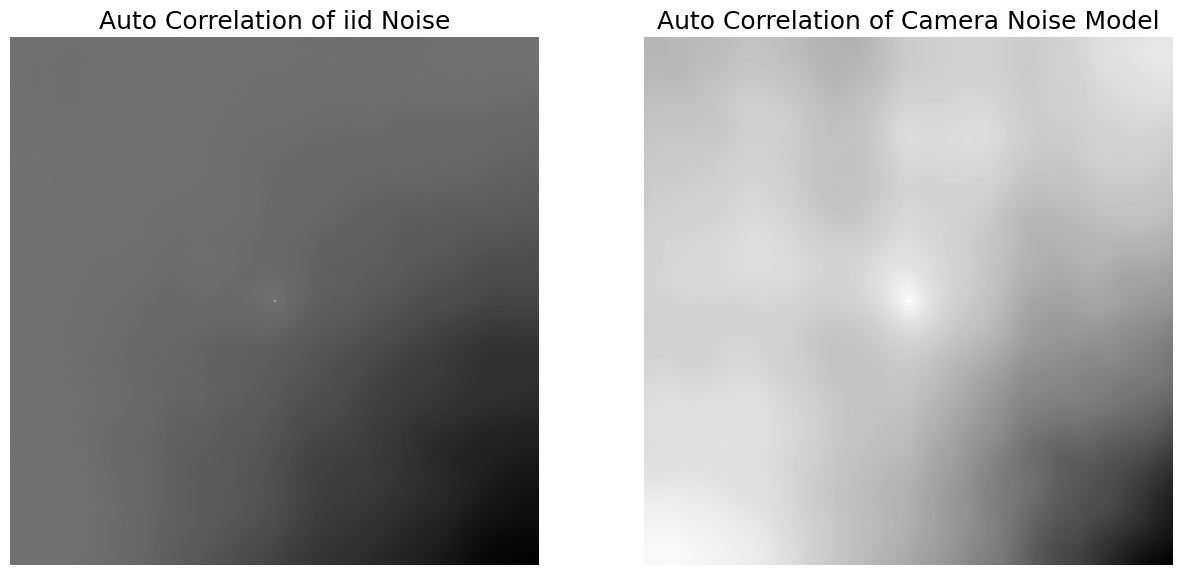

In [64]:
from matplotlib import colors

_, ax = plt.subplots(1, 2, figsize=(15,10))

ax[0].imshow(iid_auto_corr[:, :, 0], norm=colors.LogNorm(), cmap='gray')
ax[0].axis(False)
ax[0].set_title("Auto Correlation of iid Noise", size=18)

ax[1].imshow(cam_auto_corr[:, :, 0], norm=colors.LogNorm(), cmap='gray')
ax[1].axis(False)
ax[1].set_title("Auto Correlation of Camera Noise Model", size=18);

In [37]:
u1, v1 = np.linalg.eig(cv2.cvtColor(I_n1, cv2.COLOR_RGB2GRAY))
u2, v2 = np.linalg.eig(cv2.cvtColor(I_n2, cv2.COLOR_RGB2GRAY))

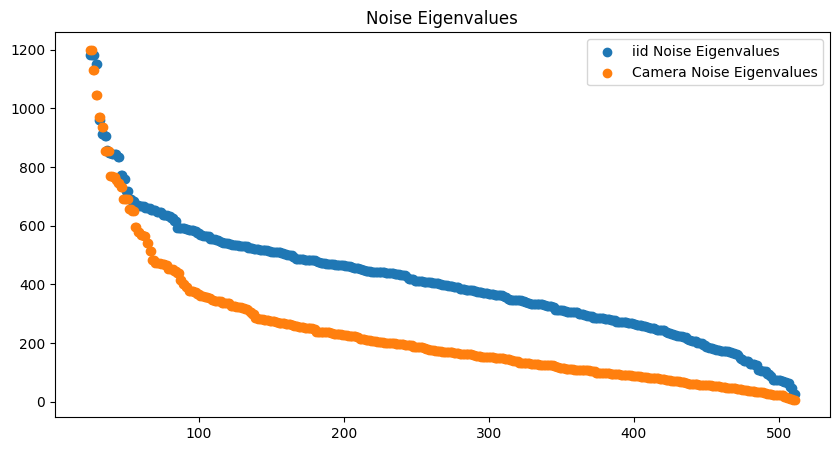

In [43]:
plt.scatter(np.arange(25, len(u1)), np.sort(np.abs(u1))[::-1][25:], label="iid Noise Eigenvalues")
plt.scatter(np.arange(25, len(u2)), np.sort(np.abs(u2))[::-1][25:], label="Camera Noise Eigenvalues")
plt.title("Noise Eigenvalues")
plt.legend();

In the next notebook, we will explore the details of this noise.

## References


https://people.csail.mit.edu/billf/publications/Noise_Estimation_Single_Image.pdf

https://www1.cs.columbia.edu/CAVE/publications/pdfs/Grossberg_PAMI04.pdf

https://en.wikipedia.org/wiki/Demosaicing

Inverse Bayer - https://stackoverflow.com/questions/73894056/bayer-pattern-with-python
